<h1>Encoder-Decoder Model</h1>

# Auto Encoder, AE
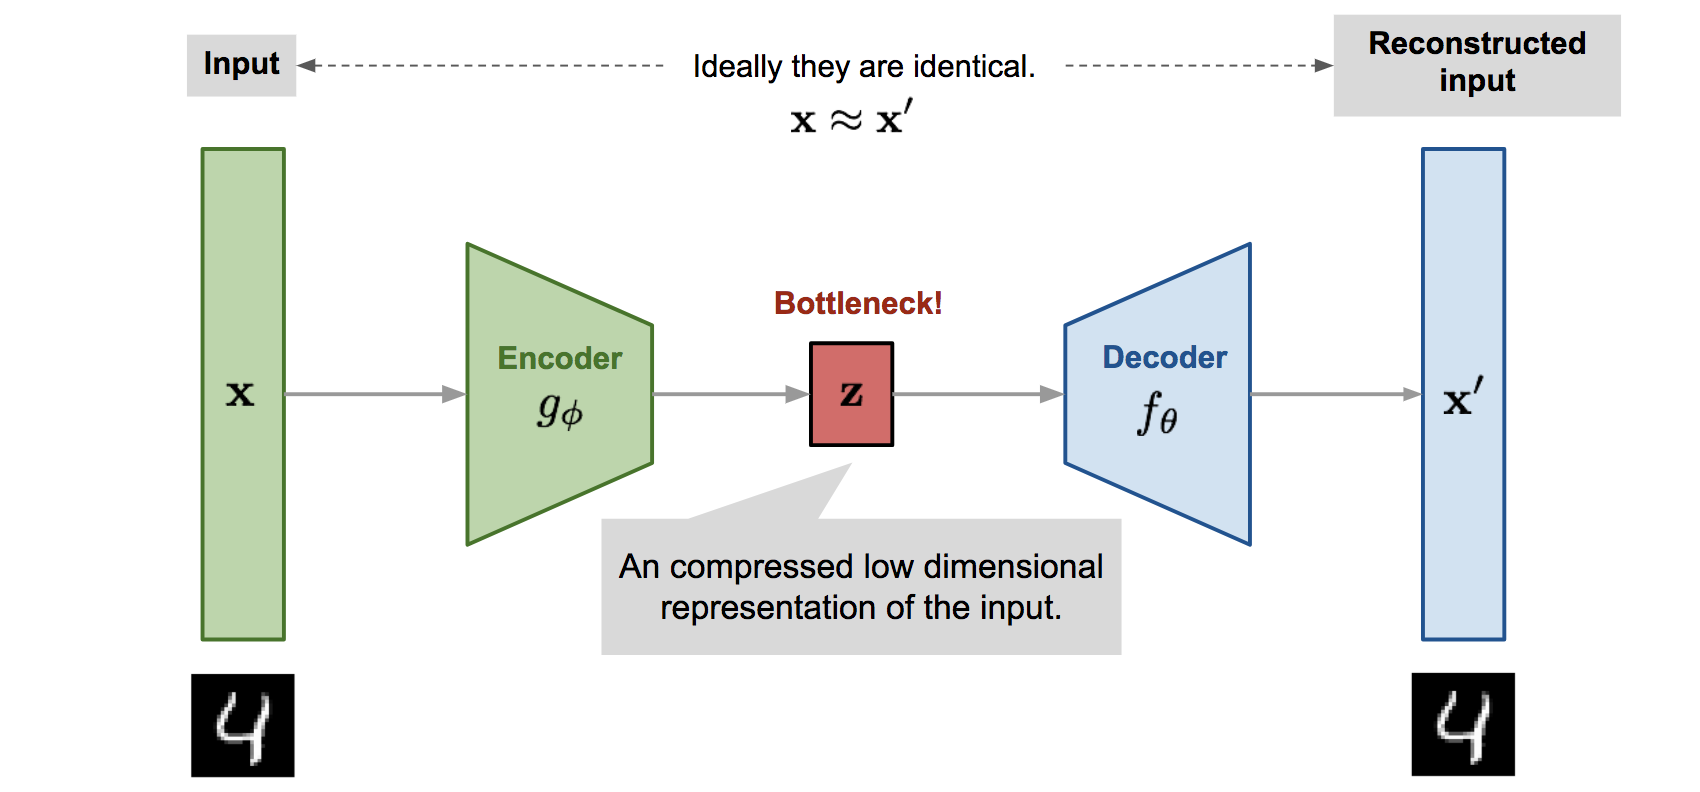

# import


In [149]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
import torchvision.datasets as ds
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torch.nn import Sequential
import torchvision.models as models

from sklearn.metrics import accuracy_score

In [150]:
device =  'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# MNIST 데이타 준비
* MNIST로 Auto Encoder를 실습힌다.

In [4]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

mnist_train = dsets.MNIST(root='.', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환, 0~1 정규화
                          download=True)

mnist_test = dsets.MNIST(root='.', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환, 0~1정규화
                         download=True)
mnist_train.data.shape, mnist_test.data.shape

100%|██████████| 9912422/9912422 [00:00<00:00, 99778274.61it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 104247585.05it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23174094.59it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21574777.77it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [65]:
batch_size=64
train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True,)
test_loader = DataLoader(dataset=mnist_test)

# AutoEncoder 모델 정의


In [108]:
class AutoEncoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = torch.nn.Sequential(
      torch.nn.Linear(784, 128),
      torch.nn.ReLU(),
      torch.nn.Linear(128, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 2),
      torch.nn.ReLU()
    )
    self.decoder = torch.nn.Sequential(
      torch.nn.Linear(2, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 128),
      torch.nn.ReLU(),
      torch.nn.Linear(128, 784),
      torch.nn.Sigmoid()
    )

  def forward(self, X):
    x = self.encoder(X)
    x = self.decoder(x)
    return x

# 모델 학습

In [102]:
def fit(model, loader, loss_fn, opt):
  n_batch = len(loader)
  loss=0
  model.train()
  for (x, y) in loader:
    x = x.reshape(-1, 784).to(device)
    y_pred = model(x)
    cost = loss_fn(y_pred, x)
    opt.zero_grad()
    cost.backward()
    opt.step()
    loss += cost.item()/n_batch
  return loss

In [118]:
torch.manual_seed(777)
torch.cuda.manual_seed(777)

model = AutoEncoder().to(device)
opt = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()


for epoch in range(20):
  train_loss = fit(model, train_loader, loss_fn, opt)
  print(f'epoch={epoch}, loss:{train_loss}')

epoch=0, loss:0.23979619564786392
epoch=1, loss:0.20793961288768845
epoch=2, loss:0.19899221638372502
epoch=3, loss:0.19476541387501067
epoch=4, loss:0.1922084810668981
epoch=5, loss:0.19021104357199362
epoch=6, loss:0.18876412947739626
epoch=7, loss:0.1877138138230421
epoch=8, loss:0.18630995763453875
epoch=9, loss:0.1848619510211162
epoch=10, loss:0.18424634981765436
epoch=11, loss:0.18352455544128587
epoch=12, loss:0.18241010898593144
epoch=13, loss:0.18188718620584446
epoch=14, loss:0.18098604793487594
epoch=15, loss:0.18037527214997848
epoch=16, loss:0.17955474387099749
epoch=17, loss:0.17994053161411147
epoch=18, loss:0.17919998363391149
epoch=19, loss:0.17812963276466032


# 추론
* X_test에서 5개만 선택해서 결과 보기

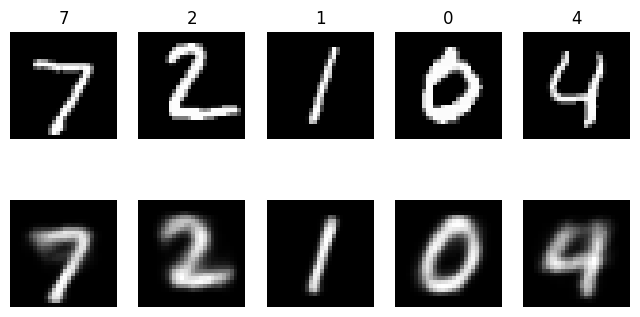

In [169]:
from torchvision.transforms.functional import to_pil_image

plt.figure(figsize=(8,4))
for i, (X, y) in enumerate(test_loader):
  pred = model(X.reshape(-1, 784).to(device))

  plt.subplot(2, 5, i+1)
  #원본 이미지
  plt.imshow(to_pil_image(X.reshape(28,28)), cmap='gray')
  plt.title(y[0].item())
  plt.axis('off')

  plt.subplot(2, 5, i+5+1)
  #생성 이미지
  plt.imshow(to_pil_image(pred.reshape(28,28)), cmap='gray')
  plt.axis('off')
  if i >= 4:
      break


# Latent Vector 시각화

[[ 4.602088    4.782045  ]
 [ 0.38408333  2.3835106 ]
 [16.964102   10.3341    ]
 [ 2.1783612  12.8250675 ]
 [ 2.1364038   2.7525246 ]]


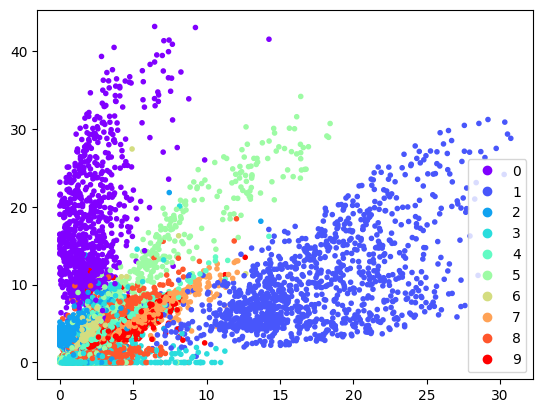

In [120]:
vec = []
for X, y in test_loader:
  pred = model.encoder(X.reshape(-1,784).to(device)).cpu().detach().numpy()
  vec.append(pred)
latent_vector = np.concatenate(vec)

scatter = plt.scatter(latent_vector[:,0], latent_vector[:,1], marker='.', c=mnist_test.targets.numpy(), cmap='rainbow')
plt.legend(scatter.legend_elements()[0], range(10));
print(latent_vector[:5])

# 이미지 생성하기
* 임의의 Vector와 Decoder로 이미지 생성하기

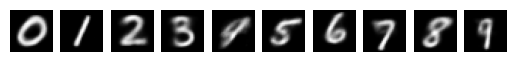

In [148]:
vector = [(2,20), (20,15),(0.1,4), (1, 0.5),(10,12), (7.5,15), (2,4), (5,5), (5,8), (5, 3.5)]
for i, (x1, x2) in enumerate(vector):
  plt.subplot(1,len(vector), i+1)
  gen_img = model.decoder(torch.FloatTensor([[x1, x2]]).to(device))
  plt.imshow(to_pil_image(gen_img.reshape(28,28)), cmap='gray')
  plt.axis('off')